# Projet n°8 : Assurer une veille technique

**Consigne:**

Réaliser une veille sur les outils et tendances en Data Science et IA afin de démontrer leur capacité ou non à dépasser en performance une modélisation déjà effectuée au cours du parcours, l'objectif est d'appréhender mes évolutions dans le domaine et apprendre à rester à jour.

**Travail à réaliser:**

- L’état de l’art devra concerner une technique datant de moins de 5 ans, présentée dans un article.
- La technique doit être référencée sur des sites de recherche (Arxiv), des sites connus (par exemple fastml, machine learning mastery, kdnuggets, import AI, MIT tech review, MIT news ML) ou des newsletters de qualité comme data elixir et data science weekly.
- Donner une explication rapide sur les concepts et techniques dans une note méthodologique (modèle en pièce-jointe) et lors d’une présentation.

*Analyse sous forme de Proove of Concept, dit POC.*

C'est une démonstration visant à démontrer l'efficacité d'un nouveau concept ou technique dans un domaine, en l'occurence dans notre situation la datascience.

# Explications sur la démarche & méthodologie employée

## Méthodologie de ce proove of concept

Nous allons comparer les deux concepts sur une tâche de classification.
Le jeu de données sera composé de deux variables textuelles qui sont :
- product_name : le nom du produit
- description : la description du produit
- avec ces deux variables nous les fusionnerons pouvoir un corpus de texte

Notre objetcif sera de retrouver notre variable cible qui est la catégorie produit.

Cette classification sera multiclasse car nous avons au total 7 catégories, répartie de manière uniforme avec 150 produits chacune (soit 1050 produits au total)

Notre objectif est de rester le plus pondéré possible entre les deux techniques c'est à dire de d'avoir une même base comparative.
En ce sens, nous allons utiliser les algorithmes de NLP pour faire l'extraction des features, soit de l'encodage de texte.
Pui, nous utiliserons le même classifier pour faire nos prédictions

# I. Importer les données & les libairies du sujet

## 1. Les librairies

In [2]:
# Librairies de base python
import sys
import os
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from threadpoolctl import threadpool_limits

# Librairie NLP
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
import torch

# Librairies pour les projections
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Modélisation supervisée
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Modélisation non-supervisée 
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from collections import defaultdict
from time import time
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import logging
#logging.basicConfig(level=logging.INFO)

# Importation des modules à partir du script associé
from Vacquerie_Justin_3_modules_092024 import *
import importlib
import Vacquerie_Justin_3_modules_092024
importlib.reload(Vacquerie_Justin_3_modules_092024)

<module 'Vacquerie_Justin_3_modules_092024' from 'C:\\Users\\justi\\OneDrive\\Cours - Travail\\DATA SCIENCE\\Formation - DataScientist\\Projet n°8\\Notebooks_Demo\\Vacquerie_Justin_3_modules_092024.py'>

*Information sur l'espace de travail du document :*

In [3]:
# Local files
print("Current working directory:", os.getcwd())
# Env utilisé
print("Environnement exécuté", sys.executable)
# Dépôt git 
#git_root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).strip().decode('utf-8')
#print('Dépôt git:',git_root)

###### Pas de git initialisé pour ce projet #######

Current working directory: C:\Users\justi\OneDrive\Cours - Travail\DATA SCIENCE\Formation - DataScientist\Projet n°8\Notebooks_Demo
Environnement exécuté C:\Users\justi\anaconda3\envs\env_poc_p8\python.exe


## 2. Les données

In [4]:
# Importation de la base de données utilisée dans le cadre du projet n°6
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [5]:
# Afficher le dataset
df.head(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


<Axes: >

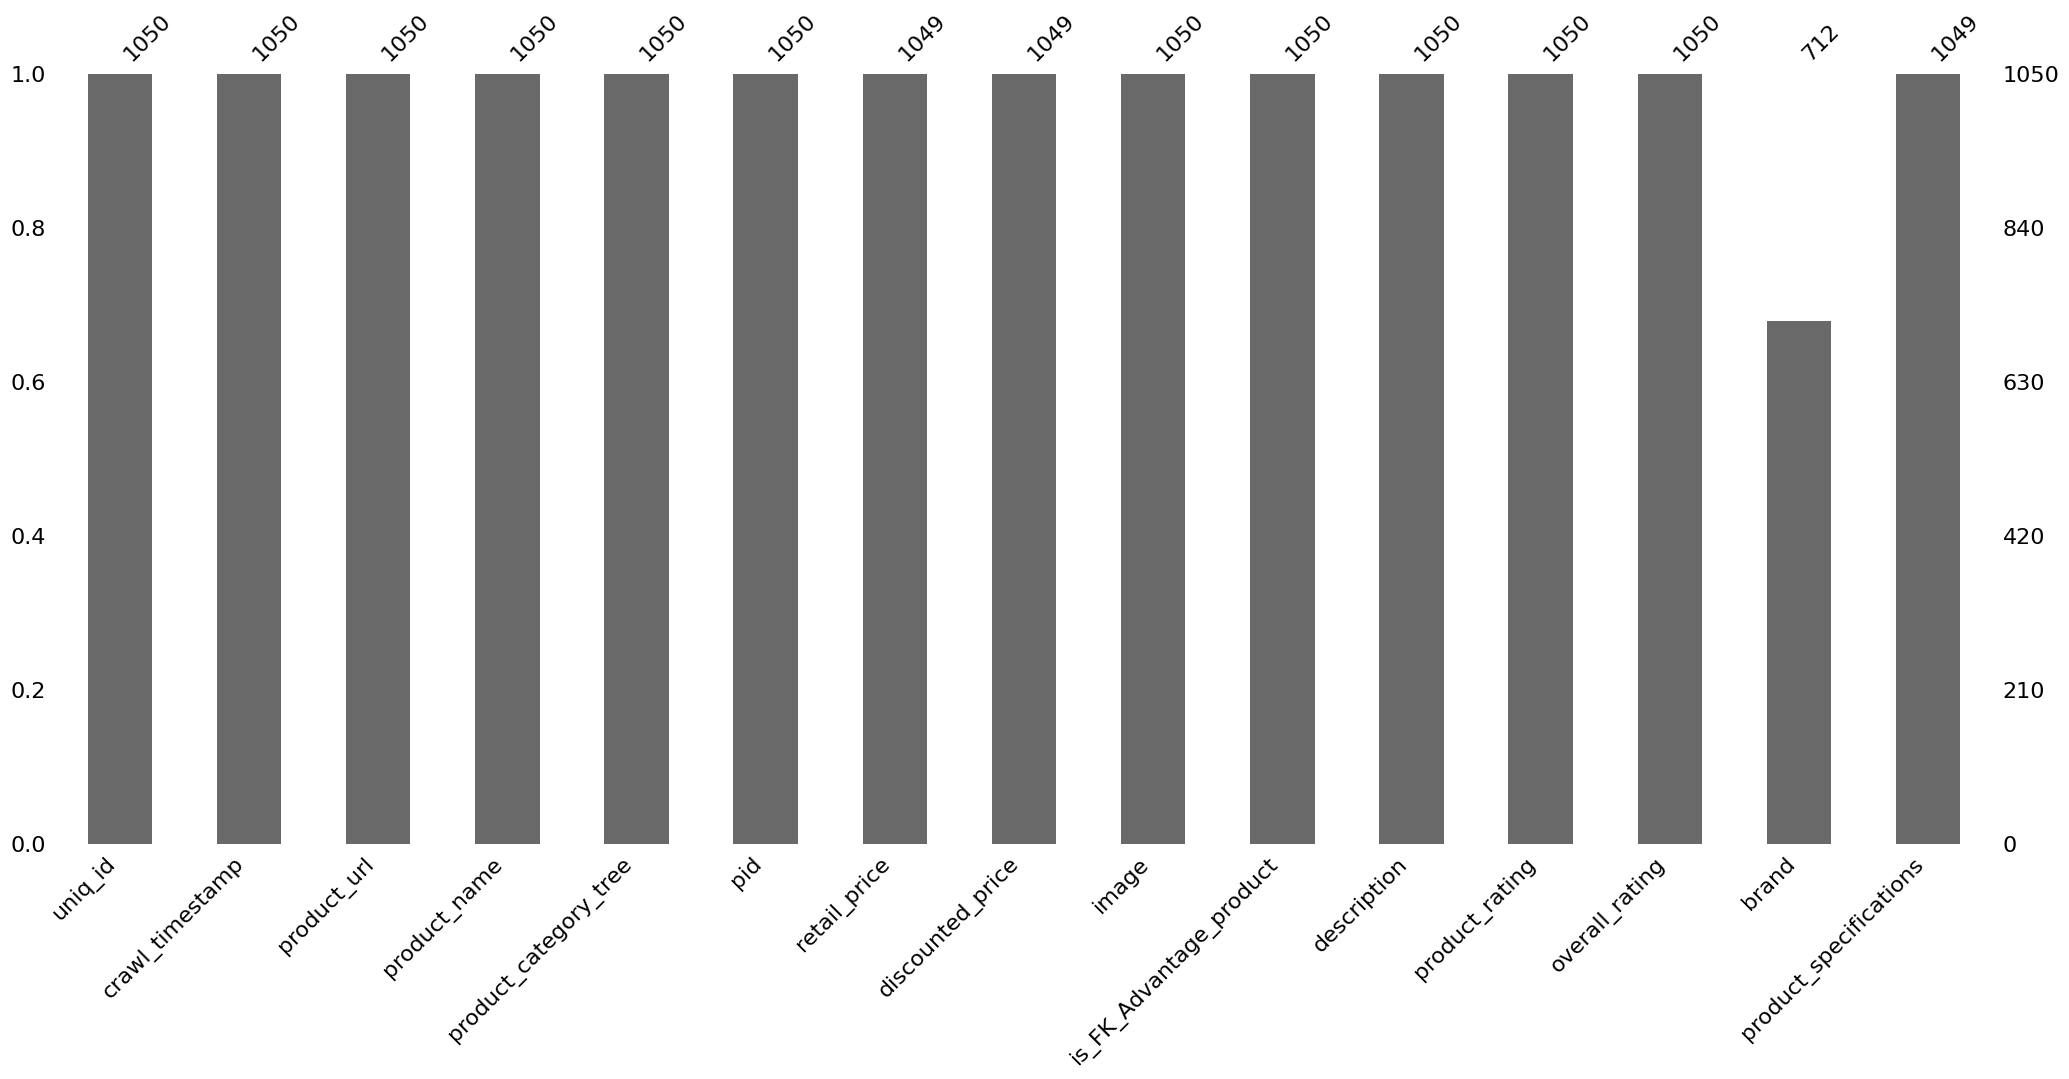

In [7]:
# Afficher le dataset et ses valeurs manquantes
msno.bar(df)

Variables avec des valeurs manquantes : 
- 'retail_price'
- 'discounted_price'
- 'brand
- 'product_specification'

## 3. Préparation du dataset

Nous allons conserver les variables qui nous intéressent pour l'étude, les voici :
- description pour le corpus de texte à analyser
- le niveau 1 de la catégorie produits qu'on appelera tout simplement "CAT_1" (notre target)
- product_name (si besoin d'un référentiel au niveau produit)

Concernant les valeurs manquantes nous sommes donc plus concernés par ce sujet.

In [8]:
# Application de la fonction de segmentation de l'arborescence des catégories produits
df = segmentation_categorie(df,'product_category_tree')

In [9]:
# Sélection des colonnes pour l'étude
selected_col = ['product_name',
                'description',
                'CAT_1']

df = df[selected_col].copy()

In [11]:
# afficher la répartition des catégories 
df.CAT_1.value_counts()

CAT_1
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

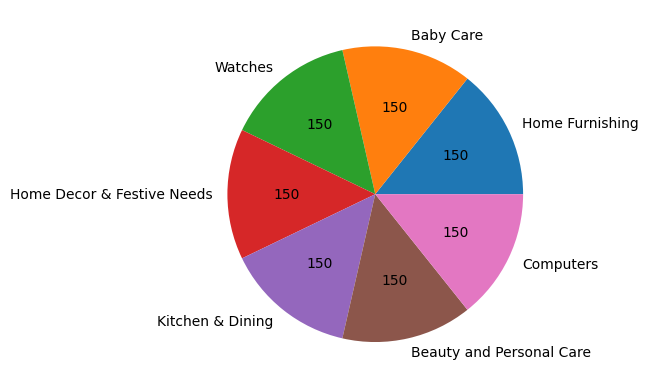

In [12]:
# Compter les valeurs de chaque catégorie
counts = df.CAT_1.value_counts()

# Afficher le graphique en secteurs
counts.plot(kind="pie", autopct=lambda p: '{:.0f}'.format(p * sum(counts) / 100))
plt.ylabel("")
plt.show()

Nous avons une répartition uniforme et homogène, pas de déséquilibrage à gérer dans le cadre des modélisations

In [13]:
# Afficher le dataset
df.head(5)

,product_name,description,CAT_1
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing


In [14]:
# transform to csv du dataframe
df.to_csv('dataset_POC.csv', index = True)

# II. Technique "traditionnelle" (2013) : "Word2Vec"

## Explications sur le fonctionnement du modèle

Word2Vec est un algorithme de modélisation de mots développé par une équipe de chercheurs de Google, dirigée par Tomas Mikolov en 2013. Il transforme des mots en vecteurs numériques de manière à ce que des mots ayant des significations similaires aient des représentations proches dans l'espace vectoriel. Il existe deux architectures principales : CBOW (Continuous Bag of Words), qui prédit un mot en fonction de son contexte, et Skip-Gram, qui prédit le contexte d'un mot donné. Le modèle est entraîné sur de grandes quantités de texte pour capturer des relations sémantiques et syntaxiques entre les mots. L'idée centrale est que les mots fréquemment utilisés ensemble dans les phrases ont une signification similaire, et donc des vecteurs proches.

## 1. Importation des datas

In [4]:
# Importation des données
df = pd.read_csv('dataset_POC.csv', index_col=0)
df.head()

,product_name,description,CAT_1
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing


## 2. Pré-traitement du corpus

 Paramètres de la fonction :
- text (str) : Le texte à traiter.
- lowercase (bool) : Si True, convertit le texte en minuscules.
- remove_digits (bool) : Si True, supprime les chiffres.
- tokenize_method (str) : Méthode de tokenisation à utiliser ('word_tokenize' par défaut).
- remove_stopwords (bool) : Si True, supprime les stopwords du texte tokenisé.
- stopwords_list (list) : Liste personnalisée de stopwords. Si None, utilise les stopwords anglais.
- stemming (bool) : Si True, applique le stemming aux tokens.
- lemmatization (bool) : Si True, applique la lemmatisation aux tokens.
- words_to_remove (list) : Liste optionnelle de mots à supprimer du texte tokenisé.


In [5]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\justi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
# Appliquer la fonction prepa_texte sur la colonne 'description'
df['corpus'] = df['description'].apply(lambda x: prepa_texte(x, 
                                                             lowercase=True, 
                                                             remove_digits=True, 
                                                             tokenize_method='word_tokenize', 
                                                             remove_stopwords=True, 
                                                             stopwords_list=None, 
                                                             stemming=False, 
                                                             lemmatization=True, 
                                                             words_to_remove=None))

In [7]:
# Afficher le df avec la nouvelle colonne 'corpus'
df.head()

,product_name,description,CAT_1,corpus
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,"[key, feature, elegance, polyester, multicolor..."
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,"[specification, sathiyas, cotton, bath, towel,..."
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,"[key, feature, eurospa, cotton, terry, face, t..."
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,"[key, feature, santosh, royal, fashion, cotton..."
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,"[key, feature, jaipur, print, cotton, floral, ..."


In [8]:
# Afficher les résulats du pré-traitement du texte
pd.set_option('display.max_colwidth', None)
df_sample = df[['description','corpus']]
df_sample.head()

,description,corpus
0,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester","[key, feature, elegance, polyester, multicolor, abstract, eyelet, door, curtain, floral, curtainelegance, polyester, multicolor, abstract, eyelet, door, curtain, cm, height, pack, price, r, curtain, enhances, look, interiorsthis, curtain, made, high, quality, polyester, fabricit, feature, eyelet, style, stitch, metal, ringit, make, room, environment, romantic, lovingthis, curtain, ant, wrinkle, anti, shrinkage, elegant, apparancegive, home, bright, modernistic, appeal, design, surreal, attention, sure, steal, heart, contemporary, eyelet, valance, curtain, slide, smoothly, draw, apart, first, thing, morning, welcome, bright, sun, ray, want, wish, good, morning, whole, world, draw, close, evening, create, special, moment, joyous, beauty, given, soothing, print, bring, home, elegant, curtain, softly, filter, light, room, ...]"
1,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel","[specification, sathiyas, cotton, bath, towel, bath, towel, red, yellow, blue, bath, towel, feature, machine, washable, yes, material, cotton, design, self, design, general, brand, sathiyas, type, bath, towel, gsm, model, name, sathiyas, cotton, bath, towel, ideal, men, woman, boy, girl, model, id, asvtwl, color, red, yellow, blue, size, mediam, dimension, length, inch, width, inch, box, number, content, sale, package, sale, package, bath, towel]"
2,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. All our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. Eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints, absorbency, softness and durability. NOTE: Our product is 100% cotton, so it is susceptible to shrinkage. Product color may vary from the picture. Size may vary by ±3% WASH CARE: Wash in cold Water, Do not Iron, Do not Bleach, Flat dry, Wash before first use. SIZE- FACE TOWEL - 23 cms X 23 cms.,Specifications of

## 3. Encodage avec le word2vec

Les hyperparamètres du modèle Word2Vec :

- sentences : corpus d'entraînement,
- vector_size : dimension des vecteurs d'embedding (ici 300),
- window : taille du contexte autour du mot (ici 20),
- min_count : fréquence minimale d'un mot pour être pris en compte (ici 3),
- workers : nombre de threads utilisés pour l'entraînement (ici 4).

In [9]:
# Création de la liste des tokens
sentences = df['corpus'].tolist()

# Entraîner le modèle Word2Vec
w2v_model = Word2Vec(sentences, vector_size=300, window=20, min_count=3, workers=4)

# Appliquer l'encodage Word2Vec à chaque entrée du corpus
df['word2vec_encoding'] = df['corpus'].apply(lambda x: get_average_word2vec(x, w2v_model, 100))

# Afficher le dataframe mis à jour avec les encodages Word2Vec
df.head()

,product_name,description,CAT_1,corpus,word2vec_encoding
0,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",Home Furnishing,"[key, feature, elegance, polyester, multicolor, abstract, eyelet, door, curtain, floral, curtainelegance, polyester, multicolor, abstract, eyelet, door, curtain, cm, height, pack, price, r, curtain, enhances, look, interiorsthis, curtain, made, high, quality, polyester, fabricit, feature, eyelet, style, stitch, metal, ringit, make, room, environment, romantic, lovingthis, curtain, ant, wrinkle, anti, shrinkage, elegant, apparancegive, home, bright, modernistic, appeal, design, surreal, attention, sure, steal, heart, contemporary, eyelet, valance, curtain, slide, smoothly, draw, apart, first, thing, morning, welcome, bright, sun, ray, want, wish, good, morning, whole, world, draw, close, evening, create, special, moment, joyous, beauty, given, soothing, print, bring, home, elegant, curtain, softly, filter, light, room, ...]","[-0.039890416, 0.20239219, -0.1507155, 0.043196104, 0.22129475, -0.31349352, 0.019237643, 0.70339996, 0.29264003, -0.28477642, -0.14798276, -0.29257473, 0.076737, -0.042836983, -0.26028618, 0.011286659, 0.10300464, 0.10395561, 0.15085402, -0.4690715, -0.15245594, 0.10069557, 0.18513122, -0.08661098, 0.2782337, 0.288984, -0.14517419, 0.036204133, -0.088135734, -0.038679145, -0.123843886, -0.21185409, 0.047519796, 0.009860339, 0.20860896, -0.036531415, -0.23697832, 0.03472525, -0.066143006, -0.07309034, 0.06755101, 0.014404975, -0.14290346, -0.28225356, 0.28786466, 0.2997698, 0.14429289, 0.33673155, 0.20483689, 0.25498164, 0.05747388, 0.25900075, 0.042011958, 0.29558206, -0.354053, 0.46198145, -0.057199903, 0.100416236, 0.16201682, 0.06880721, 0.05704996, -0.17940757, -0.2047918, -0.18030499, -0.050232753, 0.33139497, 0.12886032, -0.03318103, 0.14217697, -0.23600125, -0.06667654, 0.06524973, 0.23179922, -0.33174857, -0.18442757, 0.19757973, -0.20317492, -0.25897163, 0.0120496685, 0.4425205, -0.11645898, -0.022553004, -0.016359102, 0.2882547, 0.023286698, 0.07089596, -0.40036723, 0.02258474, 0.18930852, -0.21865481, 0.2083303, -0.1138456, 0.24489239, 0.15064834, 0.16179456, 0.18840455, 0.4242832, -0.19567135, -0.19402874, 0.16302311, ...]"
1,Sathiyas Cotton Bath Towel,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue S

## 4. Réduction de la dimension avec l'ACP

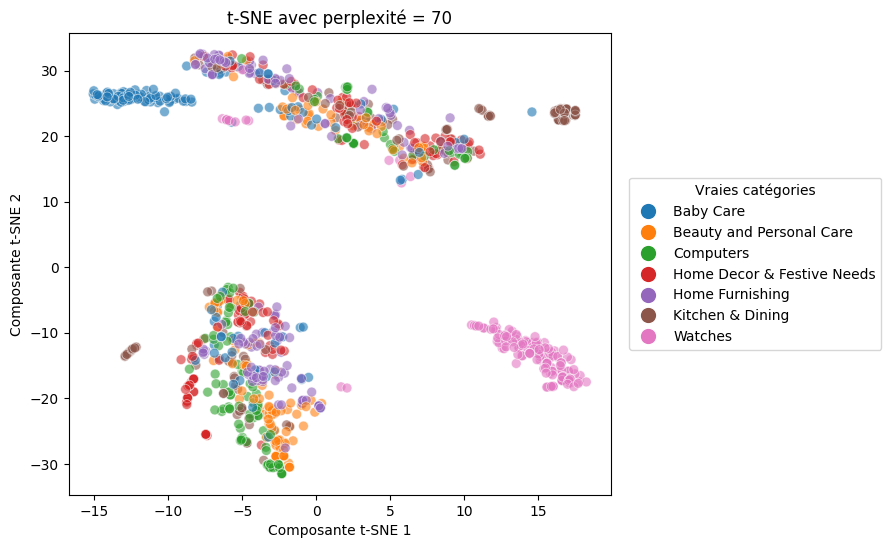

In [33]:
# Encoder la colonne 'CAT_1' avec LabelEncoder
label_encoder = LabelEncoder()
categories_encoded = label_encoder.fit_transform(df['CAT_1'])
category_names = label_encoder.classes_

# Extraire les vecteurs Word2Vec de la colonne 'word2vec_encoding'
word2vec_vectors = np.vstack(df['word2vec_encoding'].values)

# Appliquer PCA avec le pourcentage de variance à conserver
variance_conservee = 0.99
pca = PCA(n_components=variance_conservee)
reduced_word2vec = pca.fit_transform(word2vec_vectors)

# Appeler la fonction tsne_graph avec les données réduites et les catégories encodées
tsne_results = tsne_graph(reduced_word2vec, categories_encoded, category_names, perplexity=70)

## 5. Modélisation non-supervisée -- K-means

In [34]:
# Nombre de clusters
n_clusters = 7

Paramètres :
- X_data : les données sur lesquelles appliquer le K-Means.
- true_labels : les vraies étiquettes de catégories pour le calcul de l'ARI.
- label_names : les noms réels des catégories pour l'affichage.
- n_clusters : le nombre de clusters à former.
- random_state : la graine aléatoire pour la reproductibilité des résultats.
- visualize_tsne (bool) : Si True, visualise les résultats avec t-SNE.

Démarrage du KMeans clustering...
Longueur de clusters alignés: 1050
Longueur de true_labels: 1050
Silhouette Score: 0.5229
Adjusted Rand Score: 0.2153
Accuracy: 0.4410


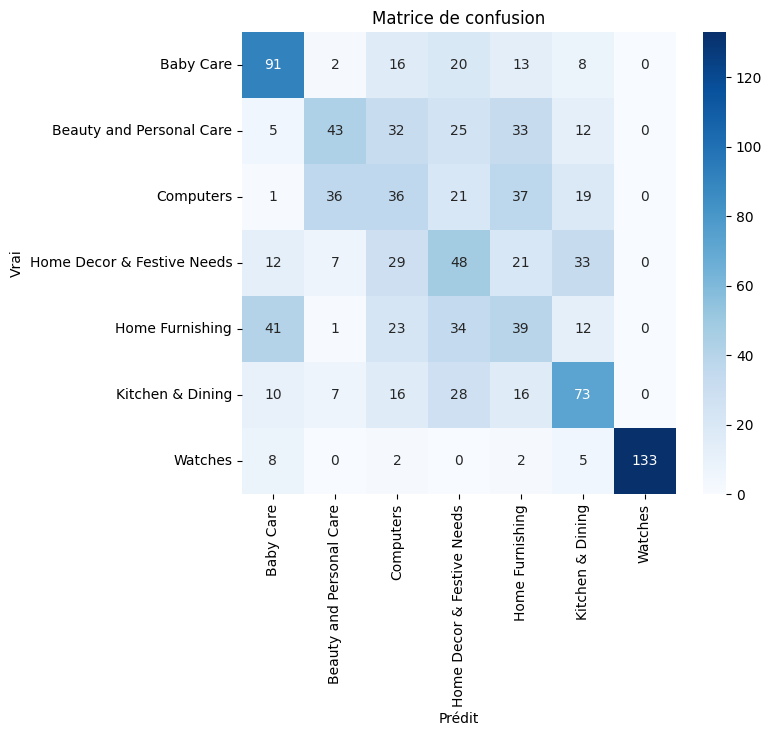

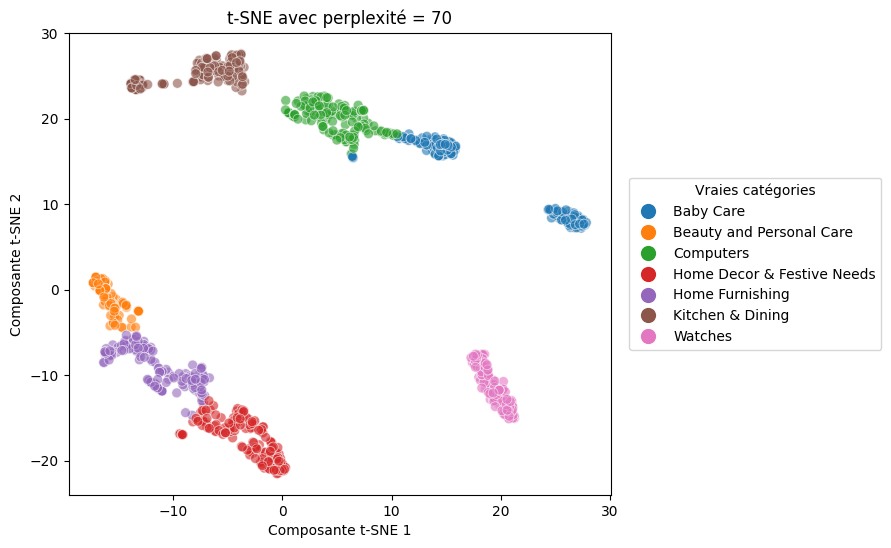

In [35]:
# Appel de la fonction à partir du script modulaire
kmeans_metrics_tsne_w2v = kmeans(X_data=tsne_results, 
                                   true_labels=categories_encoded, 
                                   label_names=category_names,
                                   n_clusters=n_clusters, 
                                   random_state=42,
                                   visualize_tsne=True,
                                   perplexity=70) 

## 6. Modélisation supervisée -- Logistic Regression

Étape 1: Extraction des embeddings et de la target...
Nombre d'échantillons: 1050, Nombre de caractéristiques: 300
Étape 2: Séparation des données en jeu d'entraînement et de test...
Jeu d'entraînement: (840, 300), Jeu de test: (210, 300)
Étape 3: Normalisation des données...
Étape 4: Application de la PCA pour réduire la dimensionnalité...
Nombre de composants principaux après PCA: 6
Étape 5: Entraînement du modèle de régression logistique...
Étape 6: Prédiction sur le jeu de test...

Étape 7: Résultats finaux
Accuracy: 0.7476190476190476

Classification Report:
                             precision    recall  f1-score   support

           Home Furnishing       0.94      0.56      0.70        27
                 Baby Care       0.55      0.81      0.65        21
                   Watches       0.86      0.79      0.82        38
Home Decor & Festive Needs       0.62      0.70      0.66        30
          Kitchen & Dining       0.71      0.71      0.71        35
  Beauty and Persona

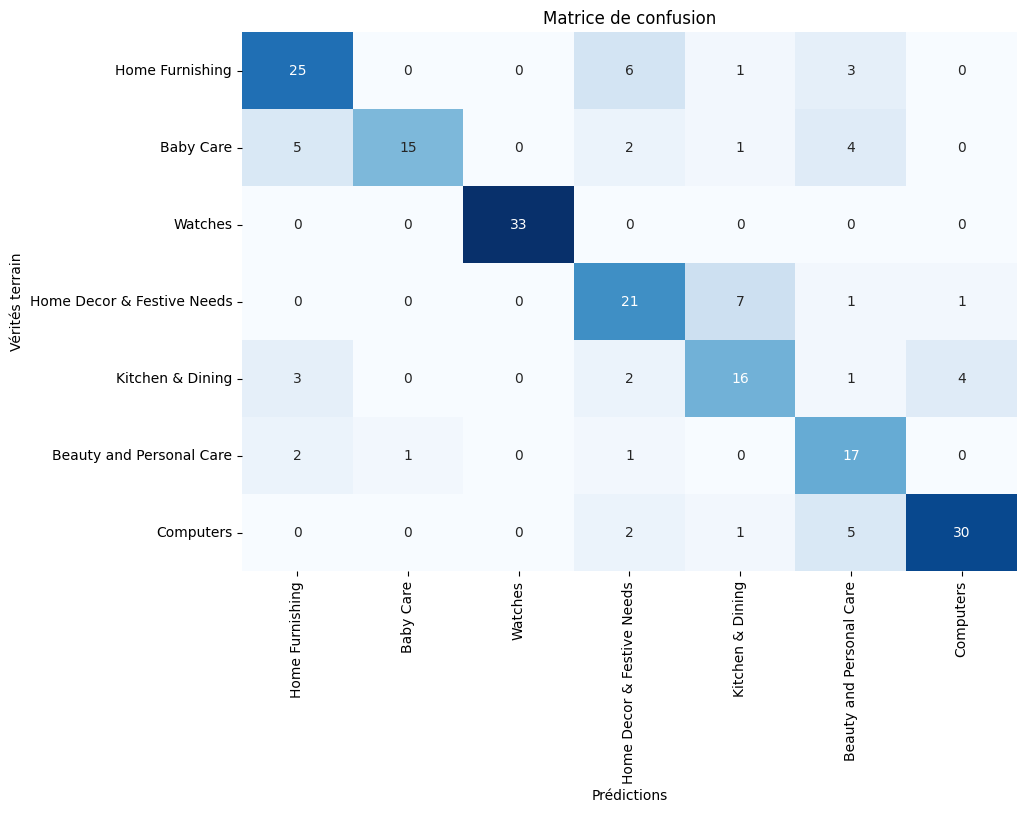

In [10]:
# Appel de la fonction pour la modélisation supervisée : obtenir l'accuracy, le report et la matrice de confusion
accuracy, classif_report, conf_matrix = classify_with_word2vec_embeddings(data=df, 
                                                                         embedding_col='word2vec_encoding', 
                                                                         target_col='CAT_1')

# III. Technique récente (2021) : MiniLMv2"

## Explication du fonctionnement du modèle

MiniLM v2 est une version améliorée du modèle MiniLM (Mini Language Model), développé par Microsoft. Il appartient à la famille des modèles d'apprentissage profond basés sur la transformer architecture et est conçu pour offrir un compromis entre performance et efficacité computationnelle dans les tâches de NLP (Natural Language Processing).

**1. Objectif de MiniLM v2**

   
Le but principal de MiniLM v2 est de fournir un modèle de taille réduite qui maintient des performances de haut niveau sur une grande variété de tâches de NLP, tout en étant beaucoup plus léger et rapide à exécuter que des modèles plus grands comme BERT, RoBERTa ou GPT. MiniLM v2 est particulièrement utile pour des applications nécessitant des calculs rapides et peu coûteux, comme les assistants virtuels, les moteurs de recherche, ou les tâches d'inférence en temps réel.

**2. Architecture**
   
MiniLM v2 est basé sur l'architecture Transformer, qui est aussi utilisée dans des modèles comme BERT et GPT. Les principales améliorations par rapport à la version originale sont :

- Compression de modèle : MiniLM v2 utilise des techniques avancées de compression des modèles comme la distillation des connaissances (knowledge distillation), qui consiste à entraîner un petit modèle (MiniLM) pour qu'il apprenne à reproduire les prédictions d'un grand modèle pré-entraîné.
- Optimisation de la structure des couches : Les concepteurs de MiniLM ont optimisé la façon dont les paramètres des couches du modèle sont partagés pour réduire la taille et les besoins en calcul sans compromettre les performances.


**4. Applications**
   
MiniLM v2 est utilisé pour des tâches NLP typiques, telles que :

- Classification de texte : Classification d’e-mails, d’avis ou de messages selon différentes catégories.
- Recherche sémantique : Utilisé pour la recherche d'informations où il est nécessaire de comprendre la signification du texte.
- Résumés automatiques : Générer des résumés concis de documents.
- Questions-Réponses : Extraction d'informations pertinentes à partir de grandes bases de données textuelles pour répondre à des questions spécifiques.
- Traduction automatique : MiniLM v2 peut être intégré dans des systèmes de traduction qui bénéficient d'une vitesse d'inférence plus rapide.
  
**5. Avantages**
   
- Léger et rapide : MiniLM v2 est beaucoup plus petit que des modèles comme BERT ou GPT, ce qui le rend plus rapide à utiliser pour des tâches d'inférence tout en consommant moins de ressources (CPU/GPU).
- Performances solides : Malgré sa taille réduite, il maintient des performances élevées, en particulier sur les tâches nécessitant des embeddings de haute qualité (comme la recherche sémantique ou la classification).


**Bibliographie:**
- https://arxiv.org/abs/2012.15828

## 1. Importation des datas

In [11]:
df = pd.read_csv('dataset_POC.csv', index_col=0)

## 2. Instanciation du modèle

In [12]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

C:\Users\justi\anaconda3\envs\env_poc_p8\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## 3. Génération des embeddings

In [13]:
# Générer les embeddings
embeddings = model.encode(df['description'].tolist(), show_progress_bar=True)

# Créer un DataFrame à partir des embeddings
embeddings_df = pd.DataFrame(embeddings, columns=[f'embedding_{i}' for i in range(embeddings.shape[1])])

# Concaténer le DataFrame des embeddings avec le DataFrame original
df = pd.concat([df, embeddings_df], axis=1)

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

## 4. Projection des embeddings avec le TSNE

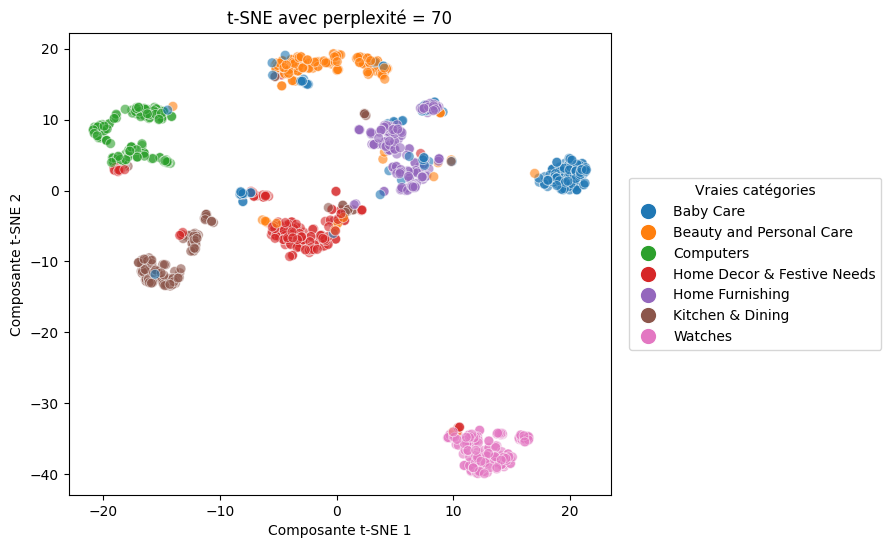

In [22]:
# Réduction dimensionnelle t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# Visualisation t-SNE
tsne_minilm =tsne_graph(embeddings_tsne, categories_encoded, category_names, perplexity=70)

## 5. Modélisation non-supervisée -- K-means

In [23]:
# Encoder la colonne 'CAT_1' avec LabelEncoder
label_encoder = LabelEncoder()
categories_encoded = label_encoder.fit_transform(df['CAT_1'])
category_names = label_encoder.classes_

Démarrage du KMeans clustering...
Longueur de clusters alignés: 1050
Longueur de true_labels: 1050
Silhouette Score: 0.6928
Adjusted Rand Score: 0.7443
Accuracy: 0.8781


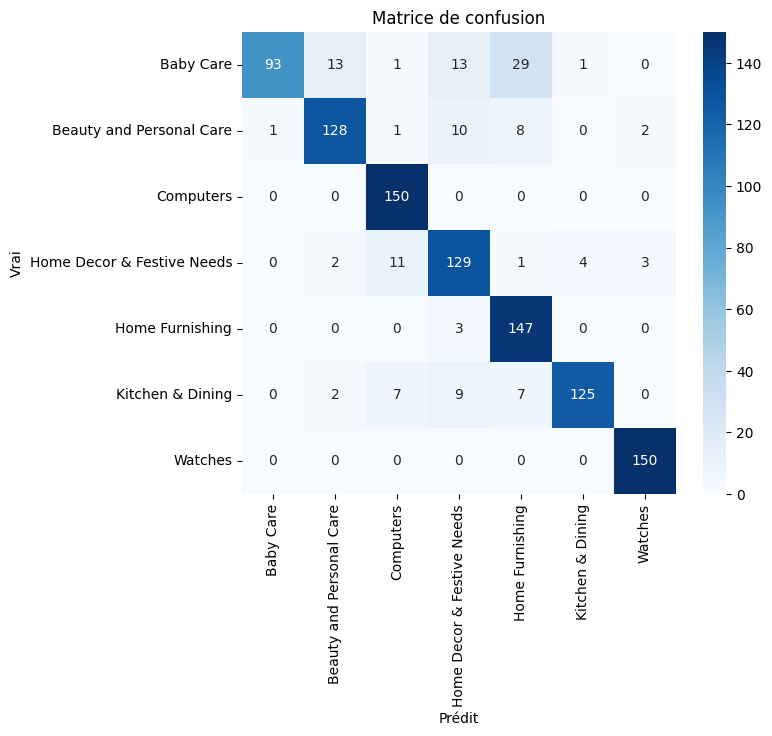

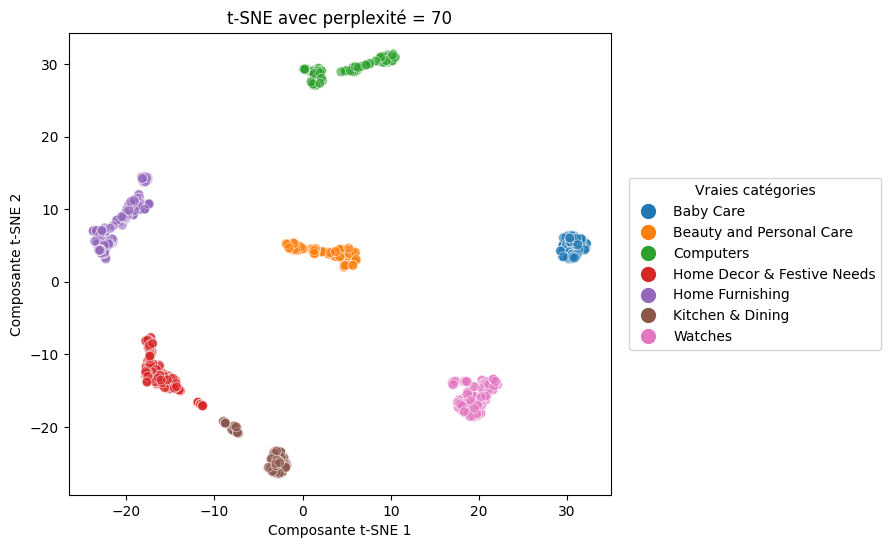

In [25]:
# Appel de la fonction du script modulaire
kmeans_metrics_tsne_minilm = kmeans(X_data=tsne_minilm,
                                    true_labels=categories_encoded, 
                                    label_names=category_names,
                                    n_clusters=7, 
                                    random_state=42,
                                    visualize_tsne=True,
                                    perplexity=70) 

## 6. Modélisation supervisée -- Logistic regression

Étape 1: Extraction des embeddings et de la target...
Nombre d'échantillons: 1050, Nombre de caractéristiques: 384
Étape 2: Séparation des données en jeu d'entraînement et de test...
Jeu d'entraînement: (840, 384), Jeu de test: (210, 384)
Étape 3: Normalisation des données...
Étape 4: Application de la PCA pour réduire la dimensionnalité...
Nombre de composants principaux après PCA: 247
Étape 5: Entraînement du modèle de régression logistique...
Étape 6: Prédiction sur le jeu de test...

Étape 7: Résultats finaux
Accuracy: 0.9523809523809523

Classification Report:
                             precision    recall  f1-score   support

           Home Furnishing       0.88      0.78      0.82        27
                 Baby Care       0.95      0.95      0.95        21
                   Watches       1.00      1.00      1.00        38
Home Decor & Festive Needs       0.91      1.00      0.95        30
          Kitchen & Dining       0.92      0.94      0.93        35
  Beauty and Perso

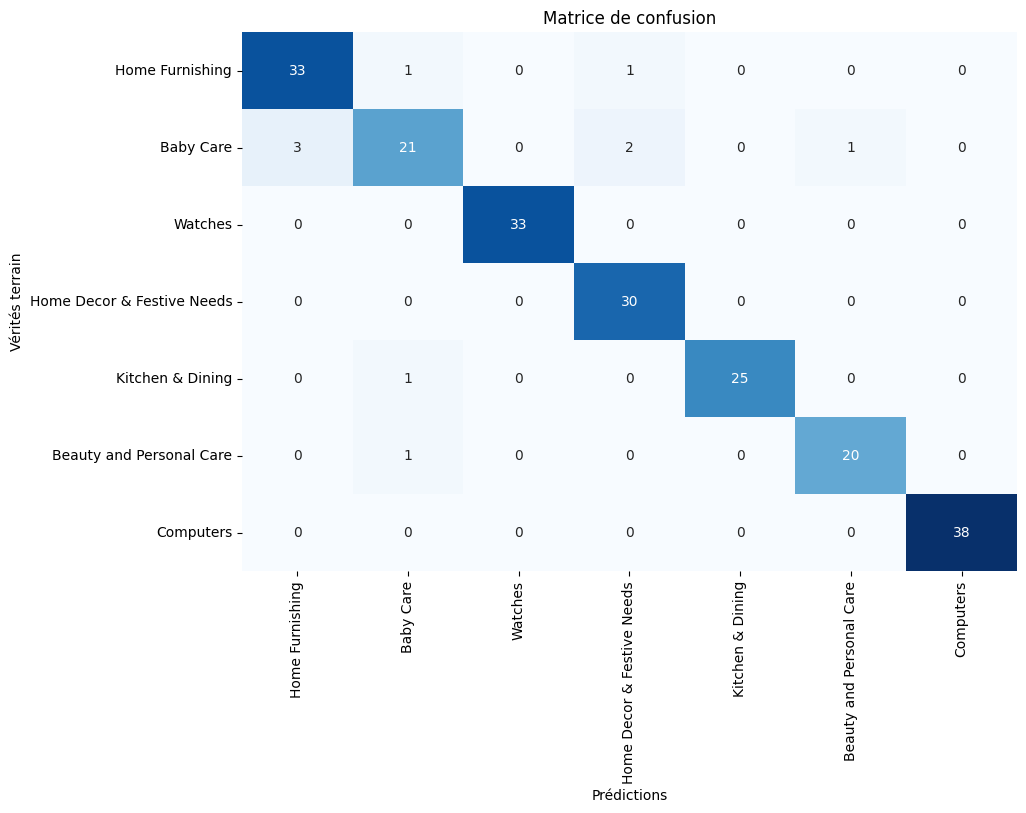

In [14]:
# Appel de la fonction pour la modélisation supervisée : obtenir l'accuracy, le report et la matrice de confusion
accuracy, classif_report, conf_matrix = classify_with_minilm_embeddings(data=df, 
                                                                        embedding_col= [col for col in df.columns if col.startswith('embedding_')], 
                                                                        target_col='CAT_1')

# IV. Conclusion sur le POC

Dans ce notebook, nous avons ainsi travailler sur un même dataset, dans le but de comparer deux techniques différentes de NLP.
La première, le word2vec, est connue et même si celle-ci est une référence dans la pratique du NLP, à l'instar du tf_idf, celle-ci commence à devenir lentement obsolète. 
Effectivement, les nouveaux de NLP, comme on peut le voir avec le minilmv2 ici, supplente le wordtovec dans les chacunes des modélisations et sur l'ensemble des métriques. 